In [1]:
%pip install git+https://github.com/smazzanti/confusion_viz
%pip install --upgrade nbformat

^C
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 77.6/77.6 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 90.4/90.4 kB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 61.2/61.2 kB ? eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [15]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif,f_classif
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

In [5]:
radiomic_features_df = pd.read_table('Data\clinical_radiomics.tsv')

In [6]:
#Clean up
radiomic_features_df = radiomic_features_df[radiomic_features_df.OS_cens == '0']

radiomic_features_df["OS_result"] = radiomic_features_df["OS"] > radiomic_features_df["OS"].median() if 'long' else 'short'
radiomic_features_df = radiomic_features_df.drop(columns=["Image","Mask","type","CT_drugs","Treatment", "intent", "Metastasis_location", 
                                                          "diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy",
                                                          "diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet",
                                                          "diagnostics_Versions_Python","diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes",
                                                          "diagnostics_Image.original_Hash", "diagnostics_Image.original_Dimensionality", "diagnostics_Image.original_Spacing",
                                                          "diagnostics_Image.original_Minimum", "OS_cens","diagnostics_Image.original_Minimum", "OS", "diagnostics_Mask.original_Hash",
                                                          "diagnostics_Mask.original_Spacing", "diagnostics_Mask.original_BoundingBox",	"diagnostics_Mask.original_VoxelNum", "N",
                                                          "diagnostics_Mask.original_Size",  "diagnostics_Image.original_Size", "diagnostics_Mask.original_CenterOfMassIndex",	"diagnostics_Mask.original_CenterOfMass",
                                                          "CT_effect", "zubrod_score", "T", "HT", "PLT", "RBC", "WBC", "ID", "MFS","MFS_cens","CT_cycles", "histopathology", "location",
                                                           "MIP","RT_fractional_dose", "HB"])


In [34]:
X = radiomic_features_df.loc[:,radiomic_features_df.columns != "OS_result"]  #independent columns
y = radiomic_features_df.loc[:,radiomic_features_df.columns == "OS_result"]    #target column i.e price range

df1 = pd.get_dummies(X['sex'])
X = pd.concat([X, df1], axis=1).reindex(X.index)
X.drop('sex', axis=1, inplace=True)
std_slc = StandardScaler()

y = np.ravel(y)
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=15)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

data = pd.DataFrame(std_slc.fit_transform(dfscores), columns=dfscores.columns, index=dfscores.index)
featureScores = pd.concat([dfcolumns,data],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores)
#featureScores = featureScores. = ['Specs','Score']  #naming the dataframe columns

                                   Specs     Score
0                                    age -0.177696
1                          RT_total_dose -0.777211
2        diagnostics_Image.original_Mean  0.007484
3     diagnostics_Image.original_Maximum -0.777211
4    diagnostics_Mask.original_VolumeNum -0.777211
..                                   ...       ...
107            original_ngtdm_Complexity -0.662917
108              original_ngtdm_Contrast  1.452005
109              original_ngtdm_Strength -0.495973
110                               FEMALE -0.777211
111                                 MALE -0.763502

[112 rows x 2 columns]


In [35]:

features = featureScores.nlargest(15,'Score')['Specs']
print(featureScores.nlargest(25,'Score'))
five_first_features = X[features [:5]] #first 5 features
five_ten_features = X[features [:10]] #first 10 features
fifteen_features = X[features] #15 features

                                                 Specs     Score
50                                  original_glcm_Imc2  2.832601
28                          original_firstorder_Median  2.278405
67                           original_glrlm_RunEntropy  2.258447
32                 original_firstorder_RootMeanSquared  2.212316
86       original_glszm_SmallAreaHighGrayLevelEmphasis  2.197341
44                     original_glcm_DifferenceAverage  2.174305
51                                   original_glcm_Idm  2.138148
29                         original_firstorder_Minimum  1.837654
103  original_gldm_SmallDependenceHighGrayLevelEmph...  1.801060
43                           original_glcm_Correlation  1.793438
40                          original_glcm_ClusterShade  1.683216
15                           original_shape_Sphericity  1.602423
42                              original_glcm_Contrast  1.475036
108                            original_ngtdm_Contrast  1.452005
16                       


5 features
[[0.25819972 0.74180028]
 [0.40886047 0.59113953]
 [0.32422944 0.67577056]]
0.7054545454545454 {'logistic_Reg__C': 51.79474679231202, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 5}
[ True  True  True False  True  True  True  True False False False  True
  True  True False  True  True  True  True  True  True  True  True]




Text(0.5, 1.0, 'Results')

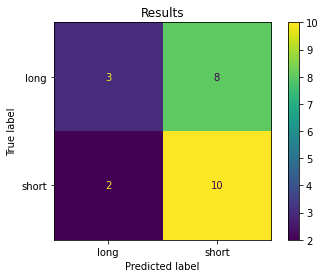

In [54]:
print("\n5 features")
X_train,X_test,y_train,y_test = train_test_split(five_first_features,y,test_size = 0.3, random_state = 0)
pca = decomposition.PCA()
std_slc = StandardScaler()
model = LogisticRegression()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', model)])

cv = KFold(n_splits=10,shuffle=True)
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)
grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs =grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print (grid_search.best_score_, grid_search.best_params_) 
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')
disp = ConfusionMatrixDisplay.from_predictions(
       y_test,y_pred,display_labels=["long","short"]
    )
disp.ax_.set_title("Results")


10 features
[[0.66055055 0.33944945]
 [0.55739654 0.44260346]
 [0.2986648  0.7013352 ]]
0.6836363636363637 {'logistic_Reg__C': 51.79474679231202, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 8}
[False False  True False  True False  True False False False False False
  True False  True False  True  True  True False  True False  True]




Text(0.5, 1.0, 'Results')

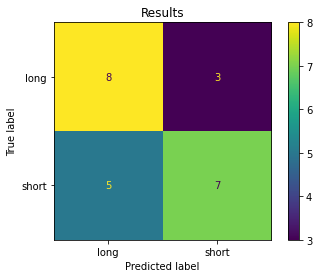

In [55]:
print("\n10 features")
X_train,X_test,y_train,y_test = train_test_split(five_ten_features,y,test_size = 0.3, random_state = 0)
pca = decomposition.PCA()
std_slc = StandardScaler()
model = LogisticRegression()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', model)])

cv = KFold(n_splits=4,shuffle=True)
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)
grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs =grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print (grid_search.best_score_, grid_search.best_params_) 
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')
disp = ConfusionMatrixDisplay.from_predictions(
       y_test,y_pred,display_labels=["long","short"]
    )
disp.ax_.set_title("Results")


15 features
[[0.16484218 0.83515782]
 [0.28438917 0.71561083]
 [0.25317258 0.74682742]]
0.6854545454545455 {'logistic_Reg__C': 24.420530945486497, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 9}
[ True  True  True False  True  True  True  True False False False False
  True False  True  True  True  True  True  True  True  True  True]




Text(0.5, 1.0, 'Results')

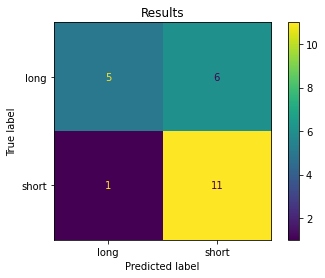

In [56]:
print("\n15 features")
X_train,X_test,y_train,y_test = train_test_split(fifteen_features,y,test_size = 0.3, random_state = 0)
pca = decomposition.PCA()
std_slc = StandardScaler()
model = LogisticRegression()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', model)])

cv = KFold(n_splits=4,shuffle=True)
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)
grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs =grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print (grid_search.best_score_, grid_search.best_params_) 
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')
disp = ConfusionMatrixDisplay.from_predictions(
       y_test,y_pred,display_labels=["long","short"]
    )
disp.ax_.set_title("Results")

[[0.55746244 0.44253756]
 [0.50149776 0.49850224]
 [0.45991442 0.54008558]]
0.7109090909090909 {'logistic_Reg__C': 0.0009540954763499944, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 6}
[False False  True False False False False False False False  True  True
  True  True False False False False False False  True  True False]




Text(0.5, 1.0, 'Results')

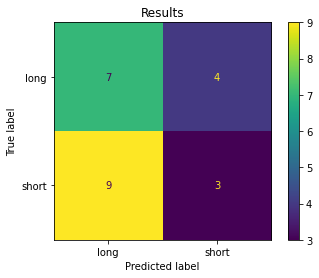

In [42]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

X = radiomic_features_df.loc[:,radiomic_features_df.columns != "OS_result"]  #independent columns
y = radiomic_features_df.loc[:,radiomic_features_df.columns == "OS_result"]  #target column i.e price range
df1 = pd.get_dummies(X['sex'])
X = pd.concat([X, df1], axis=1).reindex(X.index)
X.drop('sex', axis=1, inplace=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=33,test_size=0.3)
pca = decomposition.PCA()
std_slc = StandardScaler()
model = LogisticRegression()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', model)])

cv = KFold(n_splits=4,shuffle=True)
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
n_components = list(range(1,X.shape[1]+1,1))
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)
grid_search = GridSearchCV(pipe, parameters)

grid_search.fit(X_train, y_train)
predicted_probs =grid_search.predict_proba(X_test)
print(predicted_probs[0:3])
print (grid_search.best_score_, grid_search.best_params_) 
y_pred = grid_search.predict(X_test)
print(y_pred)
print('\n')
disp = ConfusionMatrixDisplay.from_predictions(
       y_test,y_pred,display_labels=["long","short"]
    )
disp.ax_.set_title("Results")